In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=04c7596a17216a91b3fe663a3acae380d65331fd4bb655e7db75e22501e621de
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Create a Spark session
spark = SparkSession.builder \
    .appName("Grdient Boosted Tree using PySpark - HPCI") \
    .getOrCreate()

sc = spark.sparkContext

In [ ]:
spotify_cleaned = spark.read.csv("spotify_cleaned.csv", header=True, inferSchema=True)
spotify_cleaned.printSchema()

root
 |-- track_name: string (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- artist_count: integer (nullable = true)
 |-- released_year: integer (nullable = true)
 |-- released_month: string (nullable = true)
 |-- released_day: integer (nullable = true)
 |-- in_spotify_playlists: integer (nullable = true)
 |-- in_spotify_charts: integer (nullable = true)
 |-- streams: long (nullable = true)
 |-- in_apple_playlists: integer (nullable = true)
 |-- in_apple_charts: integer (nullable = true)
 |-- in_deezer_playlists: integer (nullable = true)
 |-- in_deezer_charts: integer (nullable = true)
 |-- in_shazam_charts: integer (nullable = true)
 |-- bpm: integer (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- danceability_perc: integer (nullable = true)
 |-- valence_perc: integer (nullable = true)
 |-- energy_perc: integer (nullable = true)
 |-- acousticness_perc: integer (nullable = true)
 |-- instrumentalness_perc: integer (nullab

In [ ]:
spotify_cleaned.show()

+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+----------+------------------+---------------+-------------------+----------------+----------------+---+---+-----+-----------------+------------+-----------+-----------------+---------------------+-------------+----------------+-------+
|          track_name|         artist_name|artist_count|released_year|released_month|released_day|in_spotify_playlists|in_spotify_charts|   streams|in_apple_playlists|in_apple_charts|in_deezer_playlists|in_deezer_charts|in_shazam_charts|bpm|key| mode|danceability_perc|valence_perc|energy_perc|acousticness_perc|instrumentalness_perc|liveness_perc|speechiness_perc|cluster|
+--------------------+--------------------+------------+-------------+--------------+------------+--------------------+-----------------+----------+------------------+---------------+-------------------+----------------+----------------+---+---+-----+-

In [ ]:
spotify_cleaned = spotify_cleaned.drop("track_name", "artist_name")
spotify_cleaned.printSchema()

root
 |-- artist_count: integer (nullable = true)
 |-- released_year: integer (nullable = true)
 |-- released_month: string (nullable = true)
 |-- released_day: integer (nullable = true)
 |-- in_spotify_playlists: integer (nullable = true)
 |-- in_spotify_charts: integer (nullable = true)
 |-- streams: long (nullable = true)
 |-- in_apple_playlists: integer (nullable = true)
 |-- in_apple_charts: integer (nullable = true)
 |-- in_deezer_playlists: integer (nullable = true)
 |-- in_deezer_charts: integer (nullable = true)
 |-- in_shazam_charts: integer (nullable = true)
 |-- bpm: integer (nullable = true)
 |-- key: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- danceability_perc: integer (nullable = true)
 |-- valence_perc: integer (nullable = true)
 |-- energy_perc: integer (nullable = true)
 |-- acousticness_perc: integer (nullable = true)
 |-- instrumentalness_perc: integer (nullable = true)
 |-- liveness_perc: integer (nullable = true)
 |-- speechiness_perc: integ

In [ ]:
categorical_cols = ["released_month", "key", "mode"]

# Perform StringIndexing for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]
indexer_pipeline = Pipeline(stages=indexers)
indexed_df = indexer_pipeline.fit(spotify_cleaned).transform(spotify_cleaned)

# Perform One-Hot Encoding
encoder = OneHotEncoder(inputCols=[col+"_index" for col in categorical_cols],
                        outputCols=[col+"_encoded" for col in categorical_cols])
encoded_df = encoder.fit(indexed_df).transform(indexed_df)

# Select relevant columns for model training
selected_cols = ["artist_count", "released_year", "released_day", "in_spotify_playlists",
                 "in_spotify_charts", "in_apple_playlists", "in_apple_charts",
                 "in_deezer_playlists", "in_deezer_charts", "in_shazam_charts",
                 "bpm", "danceability_perc", "valence_perc", "energy_perc",
                 "acousticness_perc", "instrumentalness_perc", "liveness_perc",
                 "speechiness_perc", "cluster"] + [col+"_encoded" for col in categorical_cols]

# Assemble features vector
assembler = VectorAssembler(inputCols=selected_cols, outputCol="features")
assembled_df = assembler.transform(encoded_df)


In [ ]:
# Split data into train and test sets
trainingData, testData = assembled_df.randomSplit([0.7, 0.3], seed=1234)

In [ ]:
# Create GBT model with specified parameters
gbt = GBTRegressor(featuresCol="features", labelCol="streams", seed=1234)

# Train the model
gbt_model = gbt.fit(trainingData)

# Make predictions
predictions = gbt_model.transform(testData)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="streams", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Evaluate R-Squared
evaluator = RegressionEvaluator(labelCol="streams", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared (R2) on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data: 327413150.7225394
R-squared (R2) on test data = 0.711946


In [ ]:
# Create GBT model with specified parameters
gbt = GBTRegressor(featuresCol="features", labelCol="streams", maxDepth=3, maxIter=30, stepSize=0.1, seed=1234)

# Train the model
gbt_model = gbt.fit(trainingData)

# Make predictions
predictions = gbt_model.transform(testData)

# Evaluate RMSE
evaluator = RegressionEvaluator(labelCol="streams", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data:", rmse)

# Evaluate R-Squared
evaluator = RegressionEvaluator(labelCol="streams", predictionCol="prediction", metricName="r2")
r2 = evaluator.evaluate(predictions)
print("R-squared (R2) on test data = %g" % r2)

Root Mean Squared Error (RMSE) on test data: 277541628.317559
R-squared (R2) on test data = 0.793015


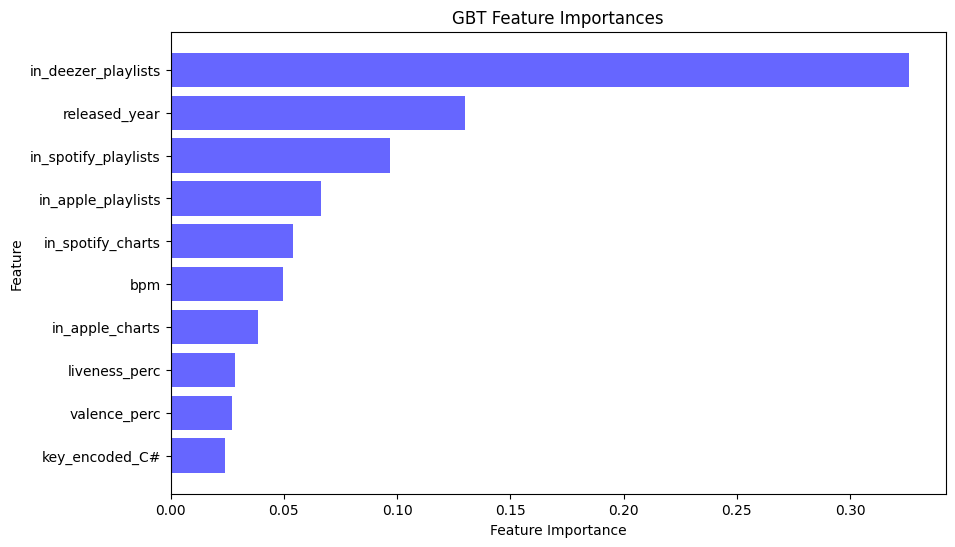

In [ ]:
# Get feature importances
feature_importances = gbt_model.featureImportances

# Get feature names
feature_names = assembled_df.schema["features"].metadata["ml_attr"]["attrs"]["numeric"] + \
                assembled_df.schema["features"].metadata["ml_attr"]["attrs"]["binary"]

# Extract importances and names into lists
importance_values = feature_importances.toArray()
feature_names = [attr['name'] for attr in feature_names]

# Sort the feature importances
sorted_indices = np.argsort(importance_values)[::-1]
sorted_importances = [importance_values[i] for i in sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names[:10], sorted_importances[:10], color="blue", alpha=0.6)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('GBT Feature Importances')
plt.gca().invert_yaxis()
plt.show()


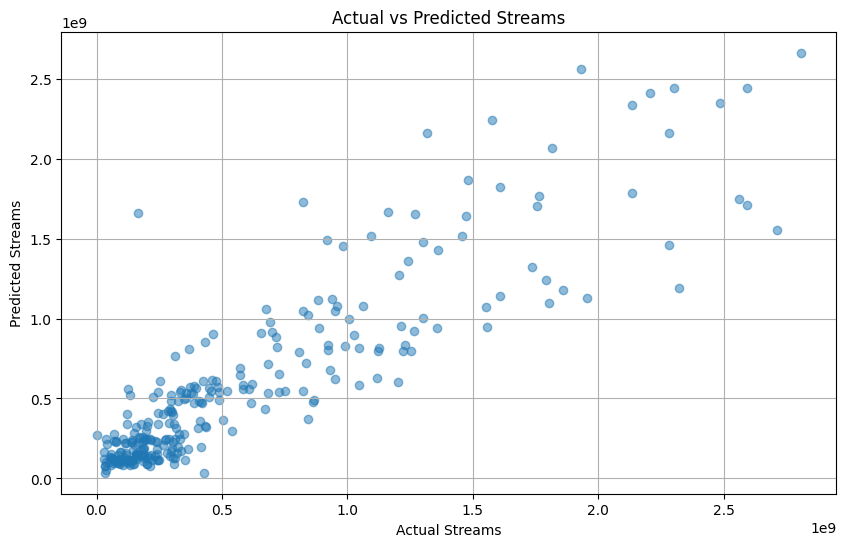

In [ ]:
# Extract actual and predicted values as lists
actual_values = predictions.select("streams").collect()
predicted_values = predictions.select("prediction").collect()

# Extracting values from Spark DataFrame to Python lists
actual_values = [row[0] for row in actual_values]
predicted_values = [row[0] for row in predicted_values]

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, alpha=0.5)
plt.xlabel('Actual Streams')
plt.ylabel('Predicted Streams')
plt.title('Actual vs Predicted Streams')
plt.grid(True)
plt.show()
